In [1]:
# 必要なパッケージを呼び出す
import numpy as np
import matplotlib.pyplot as plt
import japanize_matplotlib
from scipy.optimize import fsolve
from scipy.interpolate import interp1d 
import time

In [2]:
# MATLABではグローバル変数を使って関数への変数受け渡しを行う
# Julia/Pythonではコンストラクタを用いる

# ギリシャ文字の使用は不可とする
class Model:

    def __init__(self,beta,gamma,alpha,delta,ykss,kss,yss,css,kmax,kmin,nk,kpgrid,wpgrid,maxiter,tol):

        # カリブレーション
        self.beta = beta       # 割引因子
        self.gamma = gamma     # 相対的危険回避度(異時点間の代替弾力性の逆数)
        self.alpha = alpha     # 資本分配率 
        self.delta = delta     # 固定資本減耗(delta=1.0のときは解析解が存在) 

        # 定常状態の値
        self.ykss = ykss
        self.kss = kss
        self.yss = yss
        self.css = css

        # グリッドに関するパラメータ
        self.kmax = kmax       # 資本グリッドの最大値
        self.kmin = kmin       # 資本グリッドの最小値
        self.nk = nk           # グリッドの数
        self.kpgrid = kpgrid   # 資本グリッド(kではなく、k'についてグリッドをとる)
        self.wpgrid = wpgrid   # 富のグリッド(Carrol(2006)の手法)

        # 時間反復法に関するパラメータ
        self.maxiter = maxiter # 繰り返し計算の最大値
        self.tol = tol         # 許容誤差

In [3]:
def mu_CRRA(cons, gamma):
        """
        --------------------------------------
        === CRRA Marginal Utility Function ===
        --------------------------------------
        <inputs>
        ・m: パラメータ等を格納したコンストラクタ
        ・cons: 消費量
        <output>
        ・consとgamma の下での限界効用水準
        """
        
        mu = cons ** (-gamma)
        return mu


In [4]:
def f(m,capital,wealth):
    """
    -------------------------------------------------------------
    === 予算制約式の残差を求める関数(=0になるようなcapitalを選ぶ) ===
    -------------------------------------------------------------
    <input>
    ・m: パラメータ等を含む構造体
    ・capital: 今期の資本保有量
    ・wealth: 今期の資産保有量
    <output>
    ・res: 
    """
    res = (capital**m.alpha) + (1-m.delta)*capital - wealth
    return res

In [5]:
# メインファイル

# カリブレーション
beta = 0.96  # 割引因子
gamma = 1.0  # 相対的リスク回避度(異時点間の代替の弾力性の逆数)
alpha = 0.40 # 資本分配率
delta = 1.0  # 固定資本減耗(delta=1.0のときは解析解が存在)

# 定常状態の値
ykss = (1.0/beta-1.0+delta)/alpha
kss = ykss**(1.0/(alpha-1.0))
yss = ykss*kss
css = yss-delta*kss

# EGM
kmax = 2.0*kss;   # 資本グリッドの最大値
kmin = 0.1*kss;  # 資本グリッドの最小値(0にすると生産が出来なくなる)

# STEP 1(a): グリッド生成 
nk = 101;      # グリッドの数
kpgrid = np.linspace(kmin,kmax,nk)

# Carrol's (2005) change of variables
# cを求めた後、資源制約式をkについて解く必要がない
wpgrid = kpgrid**alpha + (1-delta)*kpgrid

# 時間反復法に関するパラメータ
maxiter = 1000 # 繰り返し計算の最大値
tol = 1e-8     # 許容誤差(STEP 2)

### EGMによる時間反復法 
(MATLAB の main_ti_egm.m に対応)

In [6]:
# 収束の基準に関するパラメータ
it = 1         # ループ・カウンター
dif2 = 1.0     # 政策関数の繰り返し誤差
tolfun = 1e-10 # 最適化の許容誤差

# 構造体にパラメータを格納
m = Model(beta,gamma,alpha,delta,ykss,kss,yss,css,kmax,kmin,nk,kpgrid,wpgrid,maxiter,tol)

print("-+- Solve a neoclassical growth model with time iteration -+-")
print(" ")

# STEP 1(b): 政策関数の初期値を当て推量
# ここでの政策関数はc'=htilde(w')となる
cfcn0 = np.copy(m.kpgrid)
cfcn1 = np.zeros(m.nk)

# 繰り返し誤差を保存する変数を設定 
dif = np.zeros((2,m.maxiter))

# 計算されたc,kを保存
cgrid = np.zeros(m.nk)
kgrid = np.zeros(m.nk)

# STEP 4: 政策関数を繰り返し計算
start = time.time()
while (it < m.maxiter) & (dif2 > tol):

    for i in range(m.nk):

        kprime = m.kpgrid[i]
        cnext = cfcn0[i] # c'=h(k'): kprimeにおけるcnextの値
        uc = m.beta*mu_CRRA(cnext,m.gamma)*(m.alpha*kprime**(m.alpha-1)+(1-m.delta));
        cons = uc**(-1/m.gamma) # mu_CRRAの逆関数

        # c + k' = k^alpha + (1-delta)*kをkについて解く
        capital = fsolve(lambda x: f(m,x,kprime+cons),[(cons+kprime)**(1/m.alpha)],xtol=tolfun)

        # 計算されたc,kを保存
        cgrid[i] = cons
        kgrid[i] = capital
    
    # 計算されたc,kから、c'=h(k')をアップデートする
    interp_c = interp1d(kgrid,cgrid,kind="linear",fill_value="extrapolate")
    cfcn1 = interp_c(m.kpgrid)

    # 繰り返し計算誤差を確認
    dif2 = np.max(np.abs(cfcn1-cfcn0))

    # 収束途中の繰り返し計算誤差を保存
    dif[1,it] = np.copy(dif2)
    
    # 政策関数をアップデート
    cfcn0 = np.copy(cfcn1)

    print(f"iteration index: {it:1d}")
    print(f"policy function iteration error: {dif2:6f}") 

    it += 1

end = time.time()
print(f"{end-start:.6f} seconds")

-+- Solve a neoclassical growth model with time iteration -+-
 
iteration index: 1
policy function iteration error: 0.098209
iteration index: 2
policy function iteration error: 0.031734
iteration index: 3
policy function iteration error: 0.011348
iteration index: 4
policy function iteration error: 0.005250
iteration index: 5
policy function iteration error: 0.002167
iteration index: 6
policy function iteration error: 0.000863
iteration index: 7
policy function iteration error: 0.000335
iteration index: 8
policy function iteration error: 0.000129
iteration index: 9
policy function iteration error: 0.000050
iteration index: 10
policy function iteration error: 0.000019
iteration index: 11
policy function iteration error: 0.000007
iteration index: 12
policy function iteration error: 0.000003
iteration index: 13
policy function iteration error: 0.000001
iteration index: 14
policy function iteration error: 0.000000
iteration index: 15
policy function iteration error: 0.000000
iteration index

In [7]:
kgrid = np.copy(kpgrid) # c'=h(k') は c=h(k)と同じ

# 最終的な政策関数が得られてから貯蓄関数を計算
pfcn0 = kgrid**m.alpha + (1-m.delta)*kgrid - cfcn0

In [8]:
# 解析的解
p_true = m.beta*m.alpha*(kgrid**m.alpha)

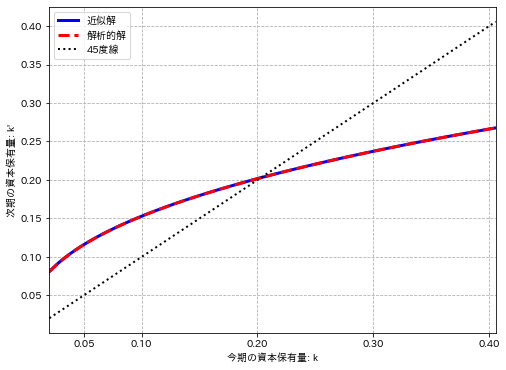

In [9]:
fig, ax = plt.subplots(figsize=(8,6))
ax.plot(kgrid,pfcn0,c="b",lw=3,label="近似解")
ax.plot(kgrid,p_true,c="r",lw=3,ls="--",label="解析的解")
ax.plot(kgrid,kgrid,c="k",lw=2,ls=":",label="45度線")
ax.set(xlabel="今期の資本保有量: k",ylabel="次期の資本保有量: k'",xlim=(m.kmin,m.kmax),xticks=[0.05,0.1,0.2,0.3,0.4])
ax.legend(loc="upper left")
ax.grid(ls="--")
plt.show()

### Carroll(2006)のEGMによる時間反復法
 (MATLAB の main_ti_eg_cov_.m に対応)

In [10]:
# 収束の基準に関するパラメータ
it = 1         # ループ・カウンター
dif2 = 1.0     # 政策関数の繰り返し誤差
tolfun = 1e-10 # 最適化の許容誤差

# 構造体にパラメータを格納
m = Model(beta,gamma,alpha,delta,ykss,kss,yss,css,kmax,kmin,nk,kpgrid,wpgrid,maxiter,tol)

print("-+- Solve a neoclassical growth model with time iteration -+-")
print(" ")

# STEP 1(b): 政策関数の初期値を当て推量
# ここでの政策関数はc'=htilde(w')となる
cfcn0 = np.copy(m.kpgrid)
cfcn1 = np.zeros(m.nk)

# 繰り返し誤差を保存する変数を設定 
dif = np.zeros((2,m.maxiter))

# 計算されたc,kを保存
cgrid = np.zeros(m.nk)
wgrid = np.zeros(m.nk)

# STEP 4: 政策関数を繰り返し計算
start = time.time()
while (it < m.maxiter) & (dif2 > tol):

    for i in range(m.nk):

        kprime = m.kpgrid[i]
        wprime = m.wpgrid[i]
        cnext = cfcn0[i]  # c'=h(w'): wprimeにおけるcnextの値
        uc = m.beta*mu_CRRA(cnext,m.gamma)*(m.alpha*kprime**(m.alpha-1)+(1-m.delta))
        cons = uc**(-1/m.gamma) # mu_CRRAの逆関数

        # w = c+k' (非線形方程式を解く必要がない)
        wealth = cons + kprime

        # 計算されたc,wを保存
        cgrid[i] = cons
        wgrid[i] = wealth
    
    # 計算されたc,wから、c'=htilde(w')をアップデートする
    interp_c = interp1d(wgrid,cgrid,kind="linear",fill_value="extrapolate");
    cfcn1 = interp_c(m.wpgrid)

    # 繰り返し計算誤差を確認
    dif2 = np.max(np.abs(cfcn1-cfcn0))

    # 収束途中の繰り返し計算誤差を保存
    dif[1,it] = np.copy(dif2);
    
    # 政策関数をアップデート
    cfcn0 = np.copy(cfcn1)

    print(f"iteration index: {it:1d}")
    print(f"policy function iteration error: {dif2:6f}") 

    it += 1

end = time.time()
print(f"{end-start:.6f} seconds")

-+- Solve a neoclassical growth model with time iteration -+-
 
iteration index: 1
policy function iteration error: 0.098226
iteration index: 2
policy function iteration error: 0.031738
iteration index: 3
policy function iteration error: 0.011346
iteration index: 4
policy function iteration error: 0.005241
iteration index: 5
policy function iteration error: 0.002166
iteration index: 6
policy function iteration error: 0.000857
iteration index: 7
policy function iteration error: 0.000333
iteration index: 8
policy function iteration error: 0.000128
iteration index: 9
policy function iteration error: 0.000049
iteration index: 10
policy function iteration error: 0.000019
iteration index: 11
policy function iteration error: 0.000007
iteration index: 12
policy function iteration error: 0.000003
iteration index: 13
policy function iteration error: 0.000001
iteration index: 14
policy function iteration error: 0.000000
iteration index: 15
policy function iteration error: 0.000000
iteration index

In [11]:
# c'=h(k') は c=h(k)と同じ
kgrid = np.copy(kpgrid) 

# 最終的な政策関数が得られてから貯蓄関数を計算
pfcn0 = kgrid**alpha + (1-delta)*kgrid - cfcn0

In [12]:
# 解析的解
p_true = beta*alpha*(kgrid**alpha)

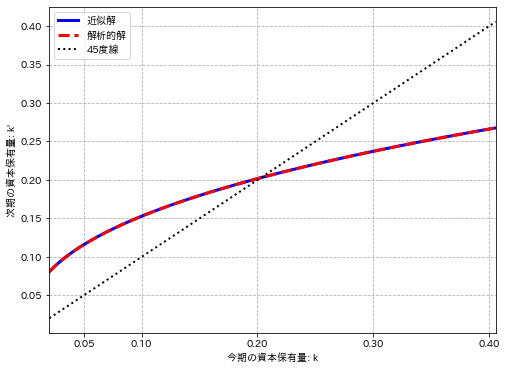

In [13]:
fig, ax = plt.subplots(figsize=(8,6))
ax.plot(kgrid,pfcn0,c="b",lw=3,label="近似解")
ax.plot(kgrid,p_true,c="r",lw=3,ls="--",label="解析的解")
ax.plot(kgrid,kgrid,c="k",lw=2,ls=":",label="45度線")
ax.set(xlabel="今期の資本保有量: k",ylabel="次期の資本保有量: k'",xlim=(m.kmin,m.kmax),xticks=[0.05,0.1,0.2,0.3,0.4])
ax.legend(loc="upper left")
ax.grid(ls="--")
plt.show()